In [234]:
import tensorflow as tf
from tensorflow import keras as kr
from keras import layers
import pandas as pd
import numpy as np
import os
from env_paths import *
import matplotlib.pyplot as plt
from global_variables import *

In [235]:
def denormalize(predictions):
    for col in INPUT_COLS:
        min, max = MIN_MAX_COLS_VALUES[col]
        predictions[col] = predictions[col] * (max - min) + min

    return predictions

def normalize(df):
    # Normalizacion de cada columna empleando (xi – minimo(x)) / (máximo(x) – minimo(x))
    for col, (min, max) in MIN_MAX_COLS_VALUES.items():
        df[col]=(df[col]-min)/(max-min)

In [236]:
files = os.listdir(CLASSIFIED_SENSOR_PATH)
df = pd.read_csv(CLASSIFIED_SENSOR_PATH + files[1])
df['ts'] = pd.to_datetime(df['ts'], unit="ns")

normalize(df)

In [237]:
learning_rate = 0.01 # Ratio de aprendizaje
batch_size = 8 # Tamanno del conjunto de datos que se introducen en bloque en entrenamiento
epochs = 100 # Epocas de entrenamiento de la RNA

In [238]:
# Instanciacion del modelo, creacion de capas y declaracion de las neuronas por capas y su funcion de activacion
inputs = layers.Input(shape=(6,1))
x = layers.GRU(64, return_sequences=True)(inputs)
x = layers.GRU(32, return_sequences=True)(x)
x = layers.GRU(16, return_sequences=True)(x)
x = layers.GRU(8)(x)
# x = layers.Dense(30, activation="sigmoid")(x)
outputs = layers.Dense(6)(x)

model = kr.Model(inputs=inputs, outputs=outputs)
es_callback = kr.callbacks.EarlyStopping(monitor="val_loss", min_delta=0.0001, patience=15)
model.compile(loss="mse", optimizer=kr.optimizers.Adam(learning_rate=learning_rate))
model.summary()

Model: "model_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_25 (InputLayer)       [(None, 6, 1)]            0         
                                                                 
 gru_96 (GRU)                (None, 6, 64)             12864     
                                                                 
 gru_97 (GRU)                (None, 6, 32)             9408      
                                                                 
 gru_98 (GRU)                (None, 6, 16)             2400      
                                                                 
 gru_99 (GRU)                (None, 8)                 624       
                                                                 
 dense_24 (Dense)            (None, 6)                 54        
                                                                 
Total params: 25,350
Trainable params: 25,350
Non-trainabl

In [239]:
X_train = pd.DataFrame()
y_train = pd.DataFrame()
X_val = pd.DataFrame()
y_val = pd.DataFrame()

rolling_win = df.groupby(pd.Grouper(freq="96H", key="ts"))
val_data_input = [] #Conjunto de datos de dentrada de validacion para graficar tras entrenamiento junto a predicciones.
val_data_target = [] #Conjunto de datos de salida de validacion para graficar tras entrenamiento junto a predicciones. 

for _, group in rolling_win: 
    if(len(group) < 4):
        continue
    
    train_size = int(0.5  * int(group.shape[0]))

    # Creacion del conjunto de datos de entrenamiento (desde el inicio de la serie temporal hasta fraccion_entrenamiento * tamano_grupo)
    train = group[0 : train_size]
    input_size = int(len(train) * 0.5)

    # Separacion de los inputs y los targets: X_train son los inputs de la RNA y y_train los targets
    X_train_group = train[INPUT_COLS].iloc[:input_size]
    y_train_group = train[INPUT_COLS].iloc[input_size :]

    X_train = pd.concat([X_train_group, X_train])
    y_train = pd.concat([y_train_group, y_train])

    val = group[train_size:]

    val_size = len(val)
    input_size = int(val_size * 0.5)

    X_val_group = val[INPUT_COLS].iloc[:input_size]
    y_val_group = val[INPUT_COLS].iloc[input_size : ]

    val_data_input.append(X_val_group)
    val_data_target.append(y_val_group)

    X_val = pd.concat([X_val, X_val_group])
    y_val = pd.concat([y_val, y_val_group])

# Entrenamiento de la RNA
history = model.fit(x=X_train, y=y_train, epochs=epochs, batch_size=batch_size, verbose='auto', validation_data=(X_val, y_val), workers=10)


Epoch 1/100
9/9 [==============================] - 14s 307ms/step - loss: 0.1061 - val_loss: 0.0130
Epoch 2/100
9/9 [==============================] - 0s 25ms/step - loss: 0.0167 - val_loss: 0.0118
Epoch 3/100
9/9 [==============================] - 0s 24ms/step - loss: 0.0116 - val_loss: 0.0089
Epoch 4/100
9/9 [==============================] - 0s 27ms/step - loss: 0.0106 - val_loss: 0.0113
Epoch 5/100
9/9 [==============================] - 0s 29ms/step - loss: 0.0098 - val_loss: 0.0088
Epoch 6/100
9/9 [==============================] - 0s 26ms/step - loss: 0.0083 - val_loss: 0.0085
Epoch 7/100
9/9 [==============================] - 0s 28ms/step - loss: 0.0084 - val_loss: 0.0078
Epoch 8/100
9/9 [==============================] - 0s 29ms/step - loss: 0.0085 - val_loss: 0.0083
Epoch 9/100
9/9 [==============================] - 0s 32ms/step - loss: 0.0084 - val_loss: 0.0096
Epoch 10/100
9/9 [==============================] - 0s 30ms/step - loss: 0.0098 - val_loss: 0.0081
Epoch 11/100
9/9 

In [240]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

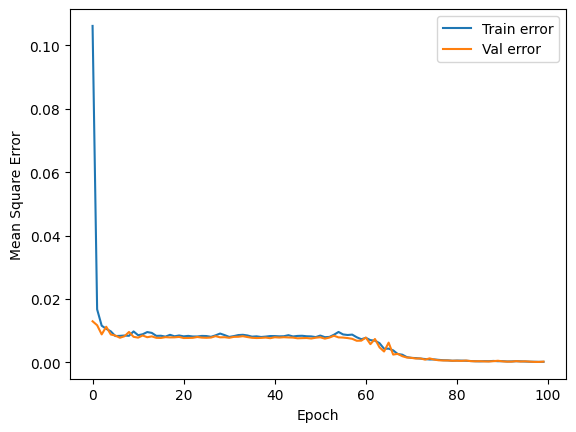

In [241]:
plt.figure()
plt.plot(hist['epoch'], hist['loss'], label='Train error')
plt.plot(hist['epoch'], hist['val_loss'], label='Val error')
plt.xlabel("Epoch")
plt.ylabel("Mean Square Error")
plt.legend()

plt.legend()

In [242]:
predictions = pd.DataFrame(columns=INPUT_COLS)
targets = pd.DataFrame(columns=INPUT_COLS)
for val_input, val_target  in zip(val_data_input, val_data_target):
    prediction = pd.DataFrame(model.predict(val_input, verbose=0), columns=INPUT_COLS)

    predictions = pd.concat([predictions, denormalize(prediction)])
    targets = pd.concat([targets, denormalize(val_target)])


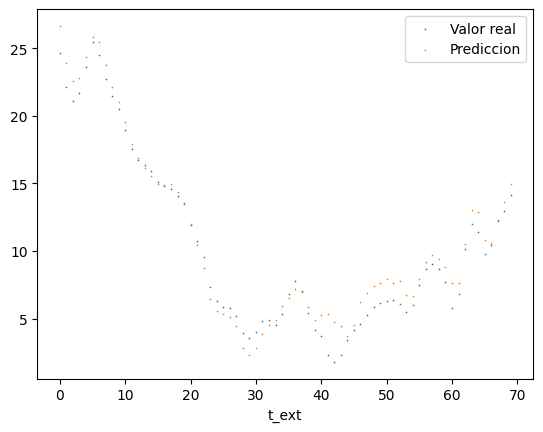

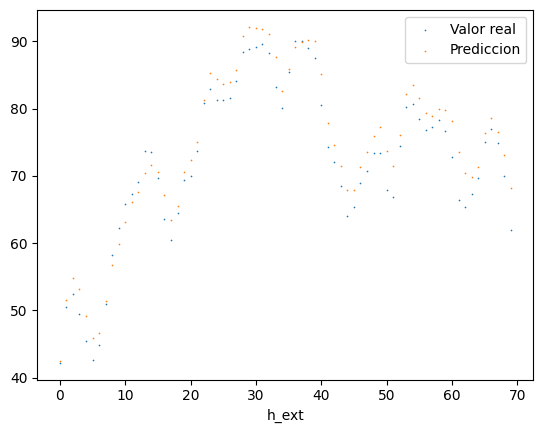

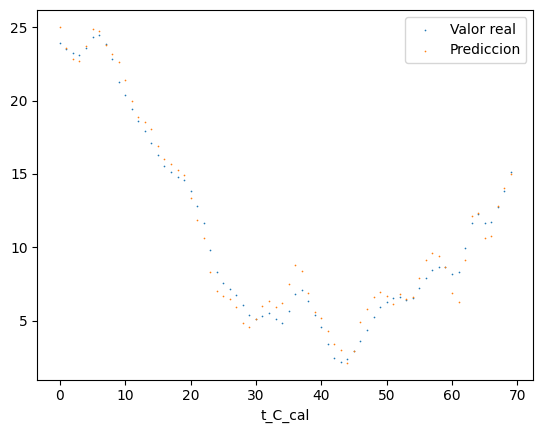

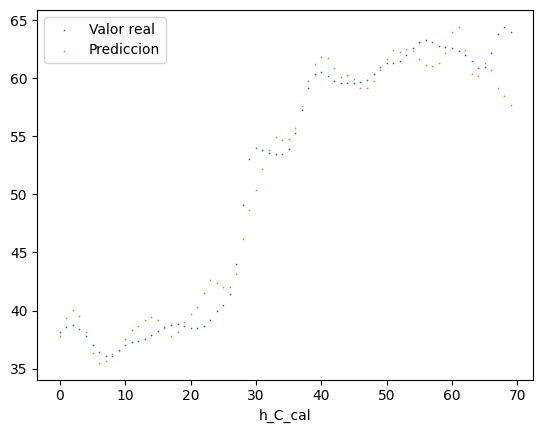

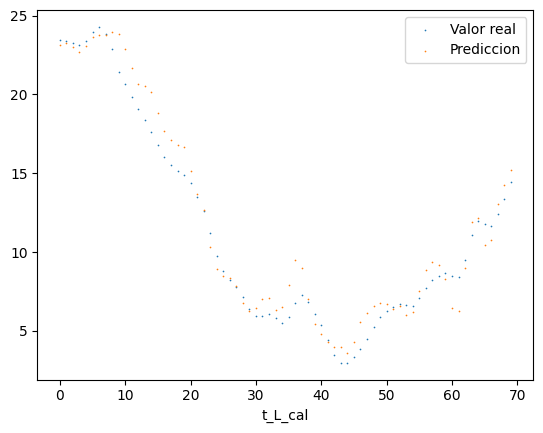

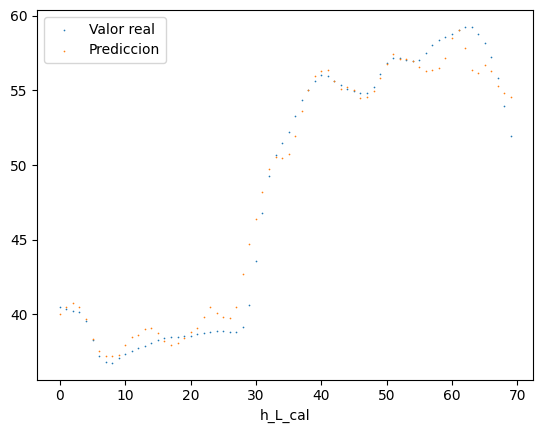

In [243]:
for col in INPUT_COLS:
    plt.figure()
    plt.scatter(range(len(targets[col])), targets[col], linewidths=0.5, s=0.5)
    plt.scatter(range(len(predictions[col])), predictions[col], linewidths=0.5, s=0.5)
    plt.legend(["Valor real", "Prediccion"])
    plt.xlabel(col)
    plt.show()

In [233]:
model.save("./ann_model", overwrite=True)

INFO:tensorflow:Assets written to: ./ann_model\assets


INFO:tensorflow:Assets written to: ./ann_model\assets
